# Visualization of the correlation between weather and rents

This script offers a visualization of the correlation between weather and demand.


In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from datetime import date, time, datetime, timedelta 

df_weather = pd.read_csv('weather.csv', sep=',')

# only use weather data from 2019
first_date = datetime(year=2019, day=1, month=1)
last_date=datetime(year=2019, day=31, month=12)

df_weather["date_time"] = pd.to_datetime(df_weather["date_time"], infer_datetime_format=True)
df19 = df_weather[(df_weather["date_time"]>=first_date)&(df_weather["date_time"]<=last_date)]

df19.sort_values(by="date_time",inplace=True)

df19.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8665 entries, 34642 to 43282
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date_time  8665 non-null   datetime64[ns]
 1   max_temp   8665 non-null   float64       
 2   min_temp   8665 non-null   float64       
 3   precip     8665 non-null   float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 338.5 KB


<ipython-input-1-d582a75f7890>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df19.sort_values(by="date_time",inplace=True)


## General temperature distribution in 2019

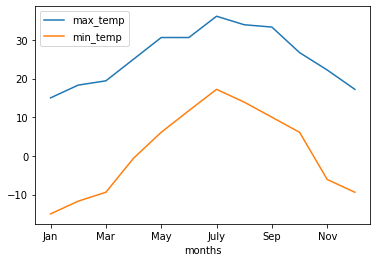

In [2]:
monthly_index = df19.set_index('date_time')
df19_monthly= monthly_index.resample('M').agg({'max_temp': np.max, 'min_temp': np.min})
df19_monthly['months'] = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'July', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

df19_monthly.set_index(['months'],inplace=True)
df19_monthly.plot()
plt.show()

## Rents per temperature

In [13]:
# import Boston 2019 dataset to find times of rents
Dataset = pd.read_csv('boston_2019.csv', sep=',')
df = pd.DataFrame(Dataset['start_time'])
df['start_time'] = pd.to_datetime(df.start_time)

# round start_time values to next nearest hour
# name it datetime so that it can be merged with the dates of the weather dataset
df['date_time'] = df['start_time'].dt.round('60min')
df = df.drop('start_time', axis='columns')
df.head()

,date_time
0,2019-01-01 00:00:00
1,2019-01-01 01:00:00
2,2019-01-01 01:00:00
3,2019-01-01 01:00:00
4,2019-01-01 01:00:00


In [15]:
newdf =df.merge(df19, on='date_time')
newdf.head()

,date_time,max_temp,min_temp,precip
0,2019-01-01 00:00:00,5.6,5.6,1.0
1,2019-01-01 01:00:00,3.9,3.9,1.0
2,2019-01-01 01:00:00,3.9,3.9,1.0
3,2019-01-01 01:00:00,3.9,3.9,1.0
4,2019-01-01 01:00:00,3.9,3.9,1.0


In [17]:
# assign a temperature intervall to each rent 

def transform_temp_to_intervall(x):
    if x < -5:
        return '[< -5]'
    if x >= -5 and x <= 0 :
        return '[-5, 0]'
    if x > 0 and x <= 5:
        return '[1, 5]'
    if x > 5 and x <= 10:
        return '[6, 10]'
    if x > 10 and x <= 15:
        return '[11, 15]'
    if x > 15 and x <= 20:
        return '[16, 20]'
    if x > 20 and x <= 25:
        return '[21, 25]'
    if x > 25:
        return '[> 25]'
    
newdf['max_temp_intervall'] = newdf['max_temp'].apply(transform_temp_to_intervall)
newdf['min_temp_intervall'] = newdf['min_temp'].apply(transform_temp_to_intervall)
newdf.head()

,date_time,max_temp,min_temp,precip,max_temp_intervall,min_temp_intervall
0,2019-01-01 00:00:00,5.6,5.6,1.0,"[6, 10]","[6, 10]"
1,2019-01-01 01:00:00,3.9,3.9,1.0,"[1, 5]","[1, 5]"
2,2019-01-01 01:00:00,3.9,3.9,1.0,"[1, 5]","[1, 5]"
3,2019-01-01 01:00:00,3.9,3.9,1.0,"[1, 5]","[1, 5]"
4,2019-01-01 01:00:00,3.9,3.9,1.0,"[1, 5]","[1, 5]"


In [67]:
min_temp_count = newdf.min_temp_intervall.value_counts()
max_temp_count = newdf.max_temp_intervall.value_counts()
print(max_temp_count)
print(min_temp_count)

[21, 25]    591260
[16, 20]    506959
[11, 15]    430335
[> 25]      384334
[6, 10]     249438
[1, 5]      206996
[-5, 0]     100366
[< -5]       26387
Name: max_temp_intervall, dtype: int64
[21, 25]    583315
[16, 20]    515420
[11, 15]    431302
[> 25]      378806
[6, 10]     250854
[1, 5]      208769
[-5, 0]     101216
[< -5]       26393
Name: min_temp_intervall, dtype: int64


Since the values of max and min temperatures don't differ too much, we will continue working with the maximum temperature values.

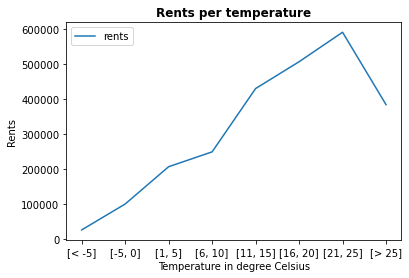

In [74]:
maxdata = pd.DataFrame(
    {"rents": [26387, 100366, 206996, 249438, 430335, 506959, 591260, 384334]}, 
    index=['[< -5]', '[-5, 0]', '[1, 5]', '[6, 10]', '[11, 15]', '[16, 20]', '[21, 25]', '[> 25]'])

maxdata.plot(label='rents')
plt.title('Rents per temperature', fontweight="bold")
plt.xlabel('Temperature in degree Celsius')
plt.ylabel('Rents')
plt.legend()

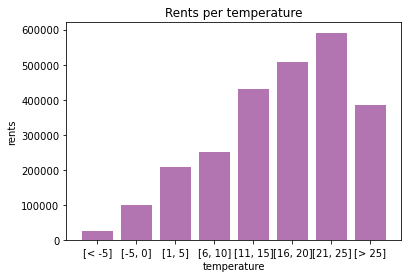

In [71]:
height = [26387, 100366, 206996, 249438, 430335, 506959, 591260, 384334]
bars = ('[< -5]', '[-5, 0]', '[1, 5]', '[6, 10]', '[11, 15]', '[16, 20]', '[21, 25]', '[> 25]')
x_pos = np.arange(len(bars))
 
# Create bars and choose color
plt.bar(x_pos, height, color = (0.5,0.1,0.5,0.6))
 
# Add title and axis names
plt.title('Rents per temperature')
plt.xlabel('temperature')
plt.ylabel('rents')
 
# Create names on the x axis
plt.xticks(x_pos, bars)
 
# Show graph
plt.show()

## Correlation between precip and rents

In [40]:
# get number of rents that took place on rainy vs non-rainy days, 1.0 = rain, 0.0 = no rain
rain_count = newdf.precip.value_counts()
rain_count

0.0    2344951
1.0     151124
Name: precip, dtype: int64

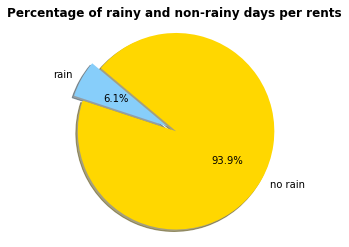

In [41]:
labels = 'rain', 'no rain'
sizes=[151124, 2344951]
colors = ['lightskyblue', 'gold']
explode = (0.1, 0)
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)
plt.title('Percentage of rainy and non-rainy days per rents', fontweight="bold")
plt.axis('equal')
plt.show()